# Preparation

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
from functions import *

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
import shap
import random
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_validate, cross_val_predict

/opt/anaconda3/envs/openclassrooms/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [3]:
def split(df):
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train = X_train.reset_index().drop('index', axis=1)
    X_test = X_test.reset_index().drop('index', axis=1)
    y_train = y_train.reset_index().drop('index', axis=1).squeeze()
    y_test = y_test.reset_index().drop('index', axis=1).squeeze()
    return X_train, X_test, y_train, y_test

In [4]:
def imputer(X_train, X_test):
    feats = [f for f in X_train.columns]
    imp = SimpleImputer(strategy='median')
    imp.fit(X_train)
    X_train_full = imp.transform(X_train)
    X_test_full = imp.transform(X_test)
    X_train_full = pd.DataFrame(columns=feats, data=X_train_full)
    X_test_full = pd.DataFrame(columns=feats, data=X_test_full)
    
    return X_train_full, X_test_full

In [5]:
df_10000 = pd.read_csv('data_transformed.csv').iloc[:, 1:]

In [6]:
df_full = pd.read_csv('data_transformed_full.csv').iloc[:, 1:]

In [37]:
df_50000 = phase1(debug = True, num_rows=50000)

Train samples: 50000, test samples: 48744
Bureau df shape: (10171, 111)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (44471, 246)
Process previous_applications - done in 2s
Pos-cash balance df shape: (42556, 15)
Process POS-CASH balance - done in 1s
Installments payments df shape: (32256, 26)
Process installments payments - done in 1s
Credit card balance df shape: (34417, 131)
Process credit card balance - done in 1s
data avant remplissage shape : (98742, 788)
data final shape : (98742, 561)


## Functions
### Score

In [7]:
from sklearn.metrics import make_scorer, confusion_matrix, SCORERS

def score_function(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    return len(y)/(10*cm[1][0] + cm[0][1])
custom_score = make_scorer(score_function, greater_is_better=True, needs_proba=False)

### Filter

In [8]:
def data_filtered(X, features_kept):
    
    X = X.loc[:, features_kept]
    return X

### Number of features

In [32]:
def num_features(df, model, num_folds):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    imp = SimpleImputer(strategy='median')
    cv = StratifiedKFold(num_folds)
    scl = MinMaxScaler()
    estimator = model
    selector = RFECV(estimator=estimator,
                    step=1,
                    cv=cv,
                    scoring='roc_auc')
    
    pipe = make_pipeline(imp, scl, selector)
    pipe.fit(X_train, y_train)
    
    result = selector.cv_results_
    print(f"Optimal number of features : {selector.n_features_}")
    
    del X_train, X_test, y_train, y_test
    
    return selector.cv_results_
 

In [10]:
def plot_num_features(result_df):
    print(f" Best mean test score : {max(result_df['mean_test_score'])} for {result_df.loc[result_df['mean_test_score']==max(result_df['mean_test_score'])].index[0]+1} features kept")
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].set_xlabel("Number of features selected")
    ax[0].set_ylabel("Cross validation score roc_auc")
    ax[0].plot( pd.DataFrame(result_df).iloc[:, 2:])
    ax[1].set_xlabel("Number of features selected")
    ax[1].set_ylabel("Mean roc_auc")
    ax[1].plot( pd.DataFrame(result_df).iloc[:, 0]);

### Features selection

In [33]:
def features_selection(df, model, nb_features):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    clf = RFE(estimator=model, n_features_to_select=nb_features, step=2, )
    steps = [('imp', imp), ('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    features = pd.DataFrame(X_train.columns)
    features_kept = features.loc[pipe['clf'].support_]
    
    del X_train, X_test, y_train, y_test
    
    return features_kept[0]

### Find best hyper parameters

In [139]:
def fine_tune_model(df, num_folds, model, features_kept, param_grid ):
    
    X_train, X_test, y_train, y_test  = split(df)
    X_train = data_filtered(X_train, features_kept)
    
    imp = SimpleImputer(strategy='median')
    cv = StratifiedKFold(num_folds)
    scl = MinMaxScaler()
    clf = model
    steps = [('imp', imp), ('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    
    search = GridSearchCV(pipe, param_grid, n_jobs=2, scoring="roc_auc", cv=cv)
    search.fit(X_train, y_train)
    
    del X_train, X_test, y_train, y_test
    
    print(f"Best parameters : {search.best_params_}")
    

### Find best threshold

In [127]:
def evaluation(df, features_kept, num_folds, model): 
    
    X_train, X_test, y_train, y_test  = split(df)
    X_train, X_test = data_filtered(X_train, features_kept), data_filtered(X_test, features_kept)
    
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    clf = model
    steps = [('imp', imp), ('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    
    # Evaluation du model par cross validation
    cv_results = cross_validate(pipe, X_train, y_train, scoring='roc_auc', cv=folds, n_jobs=2, verbose=0, fit_params=None, return_train_score=True, return_estimator=True)
    results_df = pd.DataFrame(cv_results).loc[:, ['fit_time', 'score_time', 'test_score', 'train_score']].rename(columns={'test_score': 'validation_score'}).reset_index()
    results_df = results_df.rename(columns={'index':'folds'})
    mean = results_df.mean(axis=0)
    results_df = pd.concat([results_df, mean.to_frame().T], ignore_index=True)
    results_df.iloc[-1, 0] = 'mean'
    print(results_df)

In [135]:
def best_threshold(df, features_kept, model, mini, maxi): 
    
    X_train, X_test, y_train, y_test  = split(df)
    X_train, X_test = data_filtered(X_train, features_kept), data_filtered(X_test, features_kept)
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    clf = model
    steps = [('imp', imp), ('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    train_predict = pd.DataFrame(pipe.predict_proba(X_train)[: , 1])
    test_predict = pd.DataFrame(pipe.predict_proba(X_test)[: , 1])
    
    param = np.linspace(mini, maxi,  20)
    threshold = []
    cost = []
    for i in param: 
        train_predict_class = train_predict.applymap(lambda x: 1 if x>i else 0)
        cm = confusion_matrix(y_train, train_predict_class)
        cost += [(10*cm[1][0] + cm[0][1])/len(y_train)*100]              
    ix = np.argmin(cost)
    threshold += [param[ix]]   
    best_threshold = (np.array(threshold)).mean()
    
    # roc_curve
    fpr, tpr, thresholds = roc_curve(y_train, train_predict)
    curve_train = RocCurveDisplay(fpr=fpr, tpr=tpr)
    fpr, tpr, thresholds = roc_curve(y_test, test_predict)
    curve_test = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    # Class prediction with best threshold
    train_predict_class = train_predict.applymap(lambda x: 1 if x>best_threshold else 0)
    cm_train = confusion_matrix(y_train, train_predict_class)
    cost_train = (10*cm_train[1][0] + cm_train[0][1])/len(y_train)*100
    test_predict_class = test_predict.applymap(lambda x: 1 if x>best_threshold else 0)
    cm_test = confusion_matrix(y_test, test_predict_class)
    cost_test = (10*cm_test[1][0] + cm_test[0][1])/len(y_test)*100
    
    # roc_curve with best threshold position
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    curve_train.plot(ax=ax[0])  
    curve_test.plot(ax=ax[1])
    ax[0].scatter(1-cm_train[0][0]/(cm_train[0][1]+cm_train[0][0]), cm_train[1][1]/(cm_train[1][1]+cm_train[1][0]), marker='o', color='black', label='Best', linewidths=2)
    ax[1].scatter(1-cm_test[0][0]/(cm_test[0][1]+cm_test[0][0]), cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]), marker='o', color='black', label='Best', linewidths=2)
    ax[0].set_title('Train', weight='bold')
    ax[1].set_title('Test', weight='bold')
    
    # Confusion matrix
    confusion_train = ConfusionMatrixDisplay(cm_train)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_test.plot(ax=ax[1])
    
    print(f"\nBest threshold:\t{best_threshold}\n\nroc_auc train: \t{roc_auc_score(y_train, train_predict)} \nroc_auc test: \t{roc_auc_score(y_test, test_predict)}")
    print(f"Cost train : \t{cost_train}\nCost test: \t{cost_test}")
    
    del X_train, X_test, y_train, y_test 
    
    return pipe
    
 

### Display features importance

In [14]:
def features_importance(features_kept, model_trained, num_features):
    importance_df = pd.DataFrame()
    importance_df['feature'] = features_kept
    importance_df["importance"] = model_trained['clf'].feature_importances_
    importance_df["importance"] = importance_df["importance"].apply(lambda x: abs(x))
    plt.figure(figsize=(8, num_features*1/3))
    sns.barplot(x="importance", y="feature", data=importance_df.sort_values('importance', ascending=False).iloc[:num_features, :], color='blue', saturation=0.2)
    plt.title('Features Importance')
    return importance_df.sort_values('importance', ascending=False).iloc[:num_features, :]

In [15]:
def features_importance_from_coef(features_kept, model_trained, num_features):
    importance_df = pd.DataFrame()
    importance_df['feature'] = features_kept
    importance_df["importance"] = model_trained['clf'].coef_[0]
    importance_df["importance"] = importance_df["importance"].apply(lambda x: abs(x))
    plt.figure(figsize=(8, num_features*1/3))
    sns.barplot(x="importance", y="feature", data=importance_df.sort_values('importance', ascending=False).iloc[:num_features, :], color='blue', saturation=0.2)
    plt.title('Features Importance')
    return importance_df.sort_values('importance', ascending=False).iloc[:num_features, :]

### Local features importance

In [60]:
class WaterfallData():
    def __init__ (self, shap_test, col, expected_value, data):
        self.values = shap_test[col].values
        self.base_values = expected_value
        self.data = data
        self.feature_names = shap_test.index
        self.display_data = shap_test.index

In [58]:
def local_features(X_train, X_test, y_train, nsamples, model_trained, num_features):
    
    X_train1 = model_trained['imp'].transform(X_train)
    X_train2 = model_trained['scl'].transform(X_train1)
    X_train_transformed = pd.DataFrame(columns=X_train.columns, data=X_train2)
    
    sample = shap.utils.sample(X_train_transformed, nsamples=100)
    explainer = shap.KernelExplainer(model_trained['clf'].predict_proba, sample)
    
    X_test1 = model_trained['imp'].transform(X_test)
    X_test2 = model_trained['scl'].transform(X_test1)
    X_test_transformed = pd.DataFrame(columns=X_train.columns, data=X_test2)
    
    test_index = list(X_test_transformed.index)
    i = random.choice(test_index)
    test_example = X_test_transformed.iloc[i,:]
    shap_values = explainer.shap_values(test_example)
    features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
    features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
    features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:num_features]
    expected_value =  y_train[sample.index].mean()
    
    del X_train1, X_train2, X_test1, X_test2
    
    shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=num_features)

### Bayesian optimisation

In [101]:
def clf_result(model, df, num_folds, features_kept=[], debug= False):
    
    X_train, X_test, y_train, y_test  = split(df)
    if features_kept!=[]:
        X_train = data_filtered(X_train, features_kept)
    
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    clf = model
    steps = [('imp', imp), ('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    
    # Evaluation du model par cross validation
    cv_results = cross_validate(pipe, X_train, y_train, scoring='roc_auc', cv=folds, n_jobs=2, verbose=0, fit_params=None, return_train_score=True, return_estimator=True)
 
    return cv_results['test_score'].mean()

In [20]:
X_train_full, X_test_full, y_train_full, y_test_full  = split(df_full)
features_full = X_train_full.columns

In [21]:
X_train, X_test, y_train, y_test = split(df_10000)
features = X_train.columns

In [38]:
X_train_50000, X_test_50000, y_train_50000, y_test_50000  = split(df_50000)
features_50000 = X_train_50000.columns

# Logistic regression
## With all features

In [140]:
fine_tune_model(df_10000,  
                5, 
                LogisticRegression(max_iter=500, class_weight='balanced'), 
                features, 
                {'clf__C': [0.01, 0.02, 0.03, 0.04, 0.05]} )

Best parameters : {'clf__C': 0.04}


In [141]:
evaluation(df_10000, features, 5, LogisticRegression(max_iter=500, class_weight='balanced', C=0.04))

  folds  fit_time  score_time  validation_score  train_score
0   0.0  0.688944    0.030075          0.718944     0.790543
1   1.0  0.624908    0.036467          0.725205     0.791111
2   2.0  0.612546    0.041685          0.742012     0.786469
3   3.0  0.665398    0.028964          0.748782     0.784372
4   4.0  0.415603    0.019152          0.746394     0.782711
5  mean  0.601480    0.031269          0.736267     0.787041



Best threshold:	0.5368421052631579

roc_auc train: 	0.7823699624093016 
roc_auc test: 	0.7545624617536497
Cost train : 	49.3875
Cost test: 	54.75


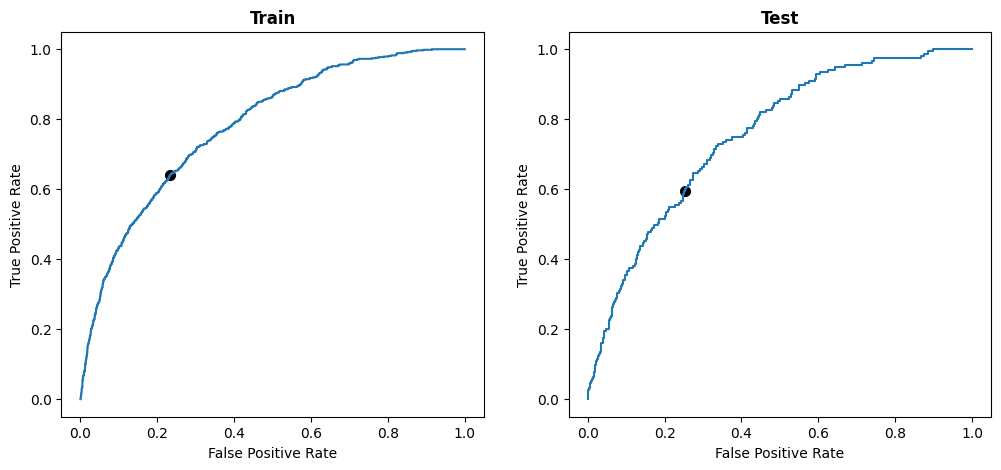

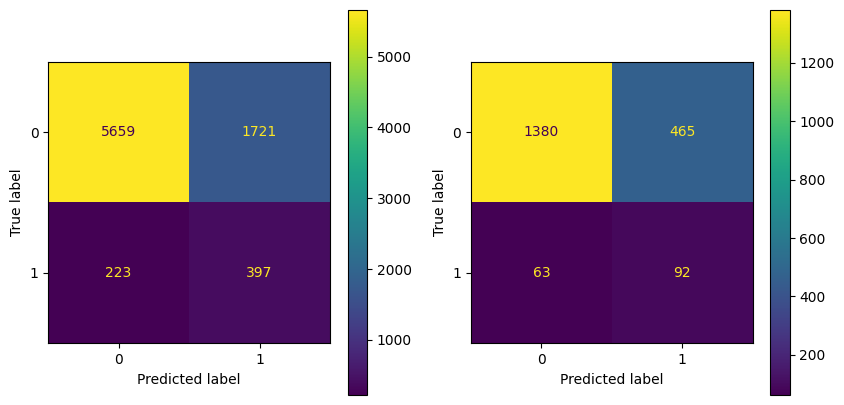

In [142]:
pipe_lr= best_threshold(df_10000,  
                        features, 
                        LogisticRegression(max_iter=500, class_weight='balanced', C=0.04), 0.5, 0.6)

In [143]:
evaluation(df_50000, features_50000, 5, LogisticRegression(max_iter=500, class_weight='balanced', C=0.04))

  folds   fit_time  score_time  validation_score  train_score
0   0.0  11.699123    0.342680          0.749565     0.757798
1   1.0  13.657132    0.219301          0.717746     0.764296
2   2.0  14.693304    0.401235          0.741447     0.759197
3   3.0  14.191019    0.201697          0.747758     0.757261
4   4.0  12.684077    0.193232          0.724827     0.762452
5  mean  13.384931    0.271629          0.736269     0.760201



Best threshold:	0.5368421052631579

roc_auc train: 	0.7578625809361079 
roc_auc test: 	0.7460369698627731
Cost train : 	52.852642632131605
Cost test: 	52.94


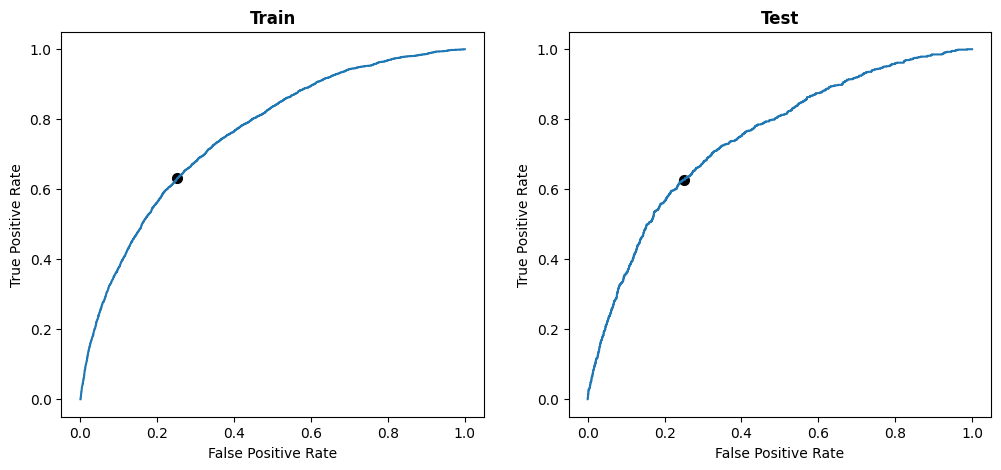

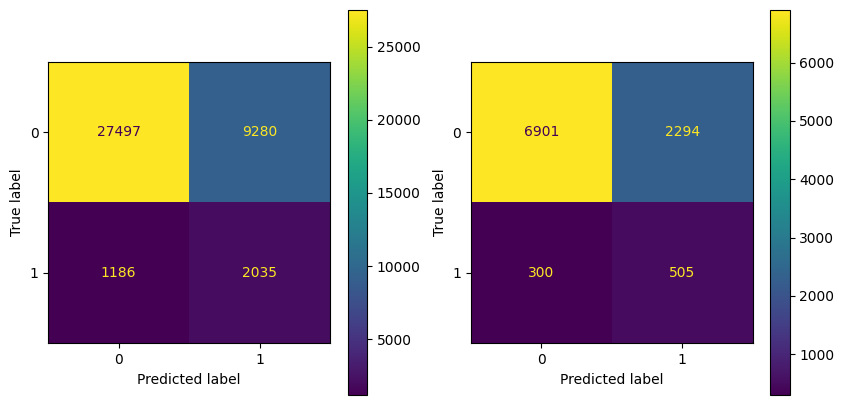

In [144]:
pipe_lr= best_threshold(df_50000,  
                        features_50000, 
                        LogisticRegression(max_iter=1000, class_weight='balanced', C=0.04), 0.5, 0.6)

,feature,importance
33,EXT_SOURCE_3,2.271637
32,EXT_SOURCE_2,1.575628
31,EXT_SOURCE_1,1.051507
254,ANNUITY_INCOME_PERC,0.936982
80,DEF_60_CNT_SOCIAL_CIRCLE,0.713880
7,AMT_ANNUITY,0.585827
93,FLAG_DOCUMENT_13,0.526401
8,AMT_GOODS_PRICE,0.525023
78,DEF_30_CNT_SOCIAL_CIRCLE,0.502157
277,PREV_CNT_PAYMENT_MEAN,0.494241


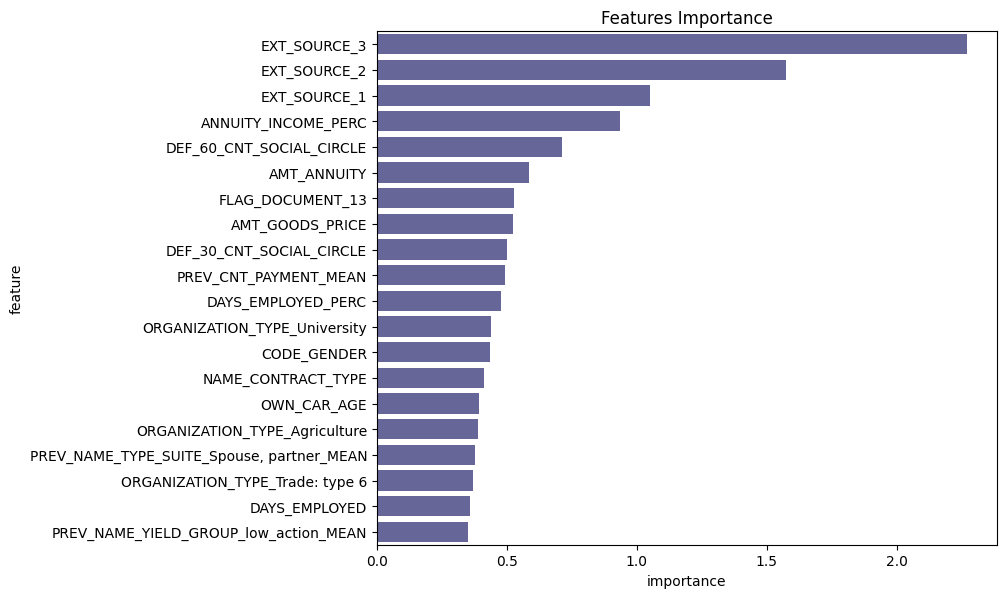

In [145]:
features_importance_from_coef(features_50000, pipe_lr, 20)

,feature,importance
33,EXT_SOURCE_3,2.271637
32,EXT_SOURCE_2,1.575628
31,EXT_SOURCE_1,1.051507
254,ANNUITY_INCOME_PERC,0.936982
80,DEF_60_CNT_SOCIAL_CIRCLE,0.713880
7,AMT_ANNUITY,0.585827
93,FLAG_DOCUMENT_13,0.526401
8,AMT_GOODS_PRICE,0.525023
78,DEF_30_CNT_SOCIAL_CIRCLE,0.502157
277,PREV_CNT_PAYMENT_MEAN,0.494241


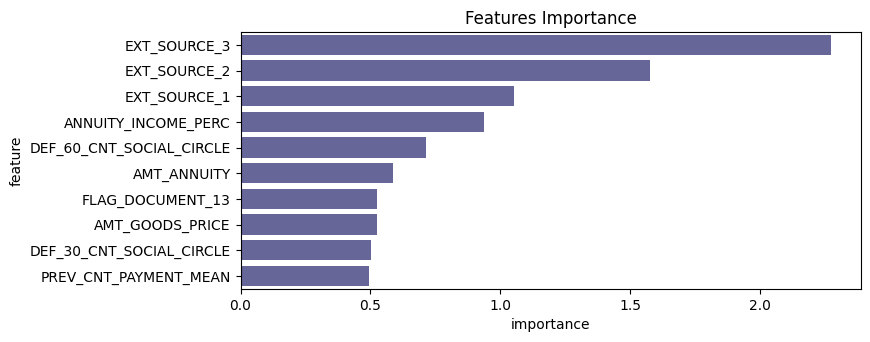

In [146]:
features_importance_from_coef(features_50000, pipe_lr, 10)

In [152]:
df_full.shape

(356251, 809)

In [153]:
evaluation(df_full,  
                        features_full, 2, 
                        LogisticRegression(max_iter=1000, class_weight='balanced', C=0.04))

  folds    fit_time  score_time  validation_score  train_score
0   0.0  209.368762   14.927111          0.763486     0.775573
1   1.0  216.053752   11.085427          0.767168     0.772135
2  mean  212.711257   13.006269          0.765327     0.773854



Best threshold:	0.5263157894736842

roc_auc train: 	0.7725690541522422 
roc_auc test: 	0.7685908403770412
Cost train : 	51.10424584866161
Cost test: 	51.411336216708406


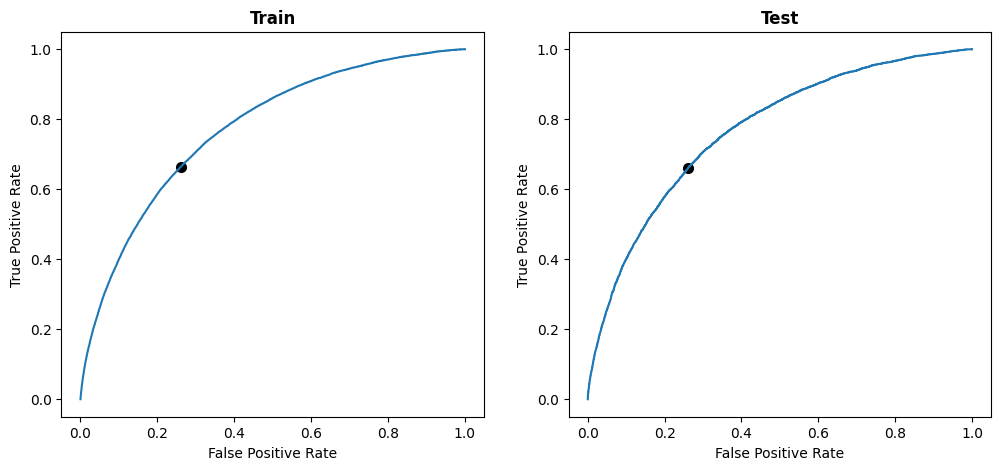

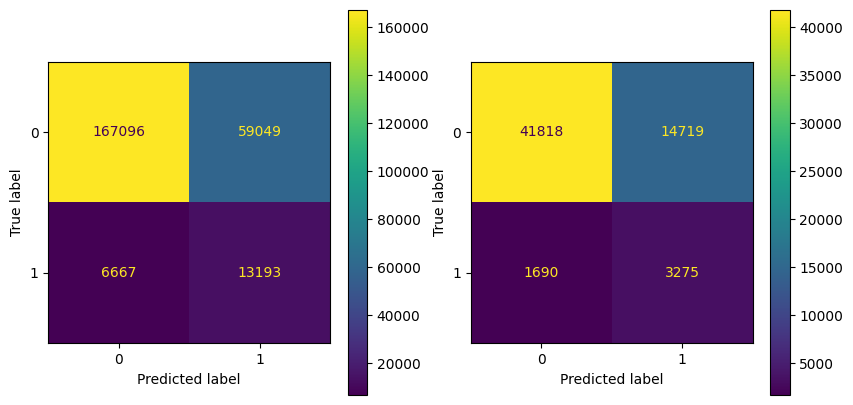

In [179]:
pipe_lr= best_threshold(df_full,  
                        features_full, 
                        LogisticRegression(max_iter=1000, class_weight='balanced', C=0.04), 0.5, 0.6)

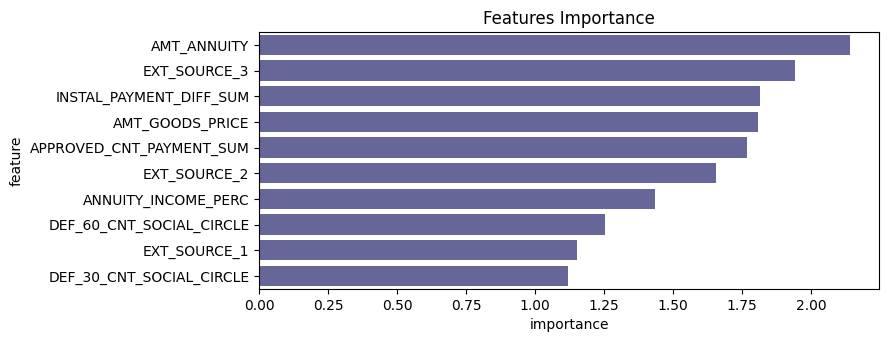

In [189]:
features_top_10 = features_importance_from_coef(features_full, pipe_lr, 10)

## Best number of features
### Find best number of features

In [46]:
result_num_features = pd.DataFrame(num_features(df_10000, 
                                                LogisticRegression(max_iter=500, C=0.04, class_weight='balanced'), 5))
result_num_features

Optimal number of features : 10


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.668583,0.015578,0.657496,0.694548,0.649218,0.674775,0.666880
1,0.722712,0.021145,0.748071,0.734289,0.685380,0.728593,0.717228
2,0.736863,0.021469,0.763944,0.742591,0.699608,0.747470,0.730702
3,0.737856,0.022388,0.763840,0.745815,0.697176,0.747940,0.734510
4,0.737961,0.024015,0.765807,0.744607,0.697346,0.755087,0.726959
...,...,...,...,...,...,...,...
249,0.739189,0.019047,0.734587,0.734822,0.724719,0.776303,0.725517
250,0.739192,0.019047,0.734598,0.734822,0.724719,0.776303,0.725517
251,0.739189,0.019047,0.734587,0.734822,0.724719,0.776303,0.725517
252,0.739189,0.019047,0.734587,0.734822,0.724719,0.776303,0.725517


 Best mean test score : 0.7470495672698662 for 10 features kept


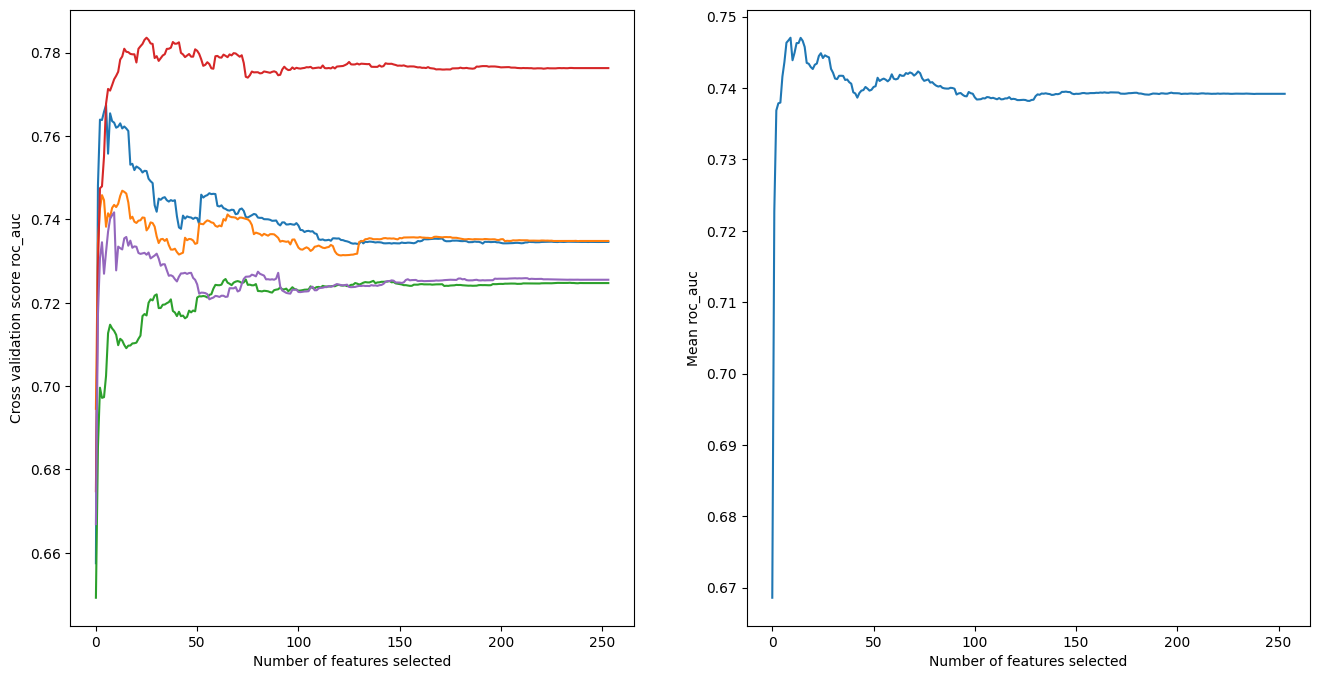

In [47]:
plot_num_features(result_num_features)

### Features selection

In [48]:
features_kept_logistic_70 = features_selection(df_10000,
                                                LogisticRegression(max_iter=500, class_weight='balanced', C=0.04), 
                                                70)

In [49]:
features_kept_logistic_70

0            NAME_CONTRACT_TYPE
1                   CODE_GENDER
4                  CNT_CHILDREN
8               AMT_GOODS_PRICE
10                   DAYS_BIRTH
                 ...           
239    WALLSMATERIAL_MODE_Mixed
247     EMERGENCYSTATE_MODE_Yes
249          DAYS_EMPLOYED_PERC
252         ANNUITY_INCOME_PERC
253                PAYMENT_RATE
Name: 0, Length: 70, dtype: object

### Find best hypermarameters

In [69]:
fine_tune_model(df_10000,  
                5, 
                LogisticRegression(max_iter=500, class_weight='balanced'), 
                features_kept_logistic_70, 
                {'clf__C': [0.18, 0.2, 0.22]} )

Best parameters : {'clf__C': 0.2}


### train model

In [156]:
evaluation(df_10000,  
                        features_kept_logistic_70, 5, 
                        LogisticRegression(max_iter=500, class_weight='balanced', C=0.2))

  folds  fit_time  score_time  validation_score  train_score
0   0.0  0.306657    0.017953          0.748372     0.788503
1   1.0  0.324799    0.019235          0.742438     0.789213
2   2.0  0.255851    0.019481          0.760594     0.785220
3   3.0  0.299712    0.010397          0.766834     0.783858
4   4.0  0.154955    0.007684          0.765233     0.781782
5  mean  0.268395    0.014950          0.756694     0.785715



Best threshold:	0.5684210526315789

roc_auc train: 	0.7827327563598216 
roc_auc test: 	0.73552233586852
Cost train : 	49.625
Cost test: 	56.699999999999996


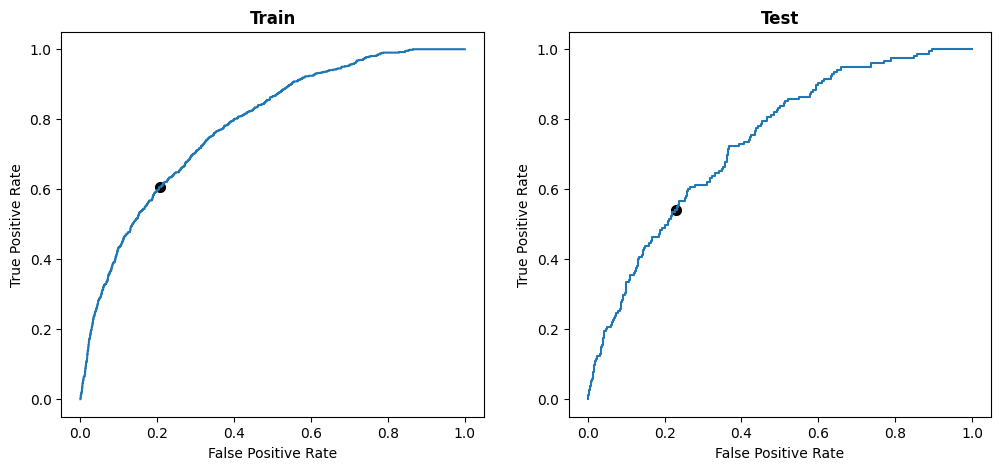

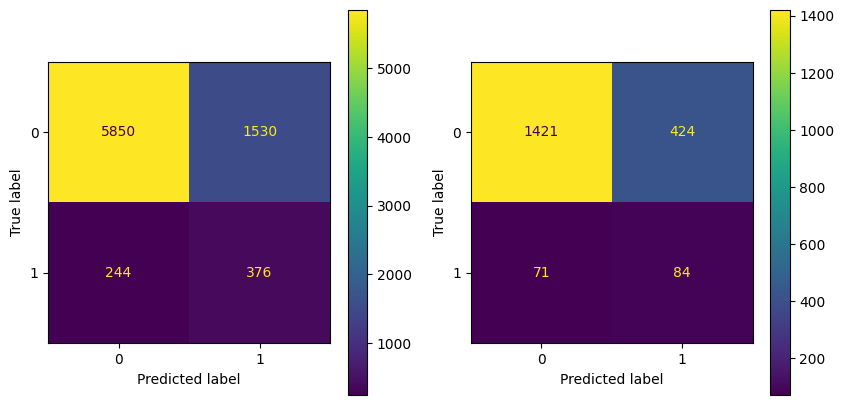

In [157]:
pipe_lr= best_threshold(df_10000,  
                        features_kept_logistic_70, 
                        LogisticRegression(max_iter=500, class_weight='balanced', C=0.2), 0.5, 0.6)

In [158]:
fine_tune_model(df_50000, 
                5, 
                LogisticRegression(max_iter=500, class_weight='balanced'), 
                features_kept_logistic_70, 
                {'clf__C': [0.08, 0.1, 0.12]} )

Best parameters : {'clf__C': 0.1}


In [180]:
evaluation(df_50000,  
                        features_kept_logistic_70, 5, 
                        LogisticRegression(max_iter=500, class_weight='balanced', C=0.1))

  folds  fit_time  score_time  validation_score  train_score
0   0.0  1.061783    0.043212          0.750414     0.744186
1   1.0  1.209794    0.039823          0.723955     0.750323
2   2.0  0.982430    0.039352          0.746887     0.744676
3   3.0  1.209970    0.029091          0.746200     0.744830
4   4.0  0.840671    0.024064          0.725446     0.749452
5  mean  1.060930    0.035108          0.738580     0.746694



Best threshold:	0.5210526315789473

roc_auc train: 	0.7458841294051834 
roc_auc test: 	0.7422643281016216
Cost train : 	54.51772588629431
Cost test: 	54.08


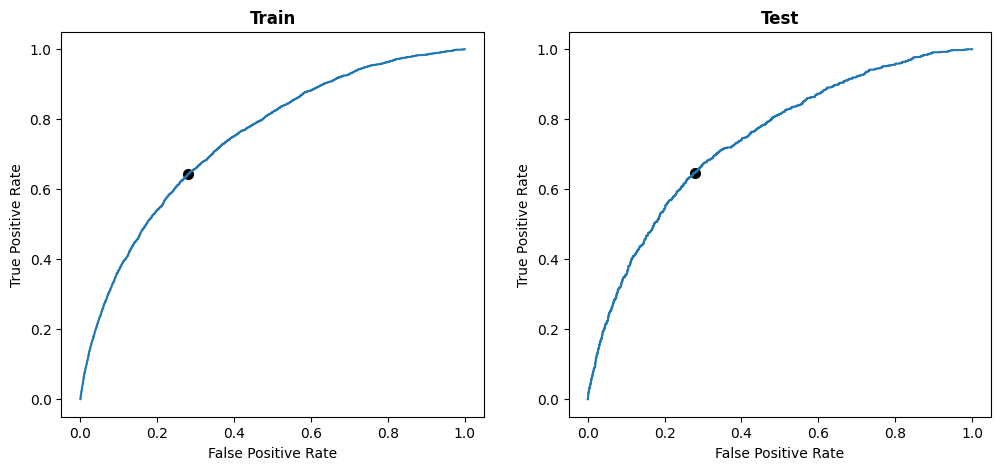

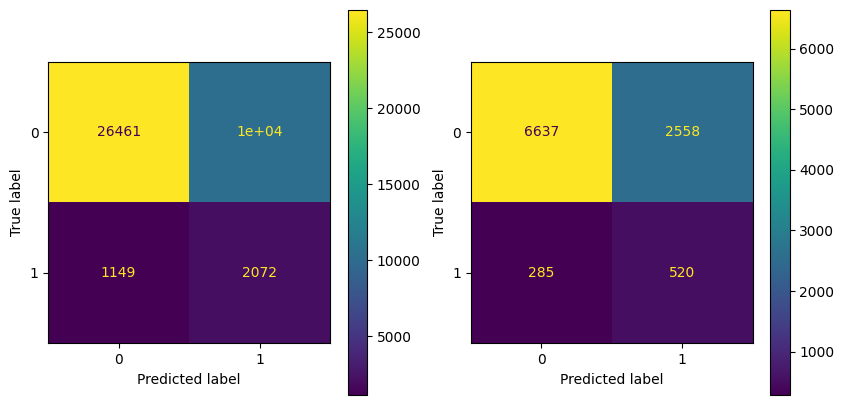

In [160]:
pipe_lr_50000= best_threshold(df_50000,  
                        features_kept_logistic_70, 
                        LogisticRegression(max_iter=500, class_weight='balanced', C=0.1), 0.5, 0.6)

### Features importance

,feature,importance
33,EXT_SOURCE_3,2.386758
252,ANNUITY_INCOME_PERC,1.672812
32,EXT_SOURCE_2,1.623400
31,EXT_SOURCE_1,1.133273
80,DEF_60_CNT_SOCIAL_CIRCLE,0.907726
8,AMT_GOODS_PRICE,0.840024
249,DAYS_EMPLOYED_PERC,0.662631
127,NAME_EDUCATION_TYPE_Lower secondary,0.485677
21,CNT_FAM_MEMBERS,0.475445
78,DEF_30_CNT_SOCIAL_CIRCLE,0.456768


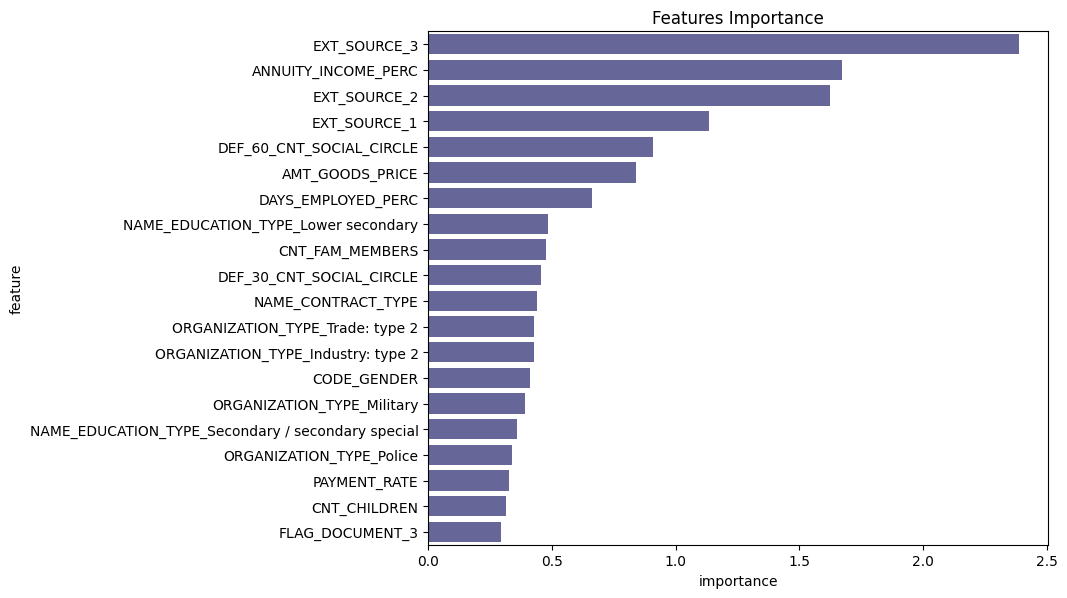

In [181]:
features_importance_from_coef(features_kept_logistic_70, pipe_lr_50000, 20)

### Local features importance

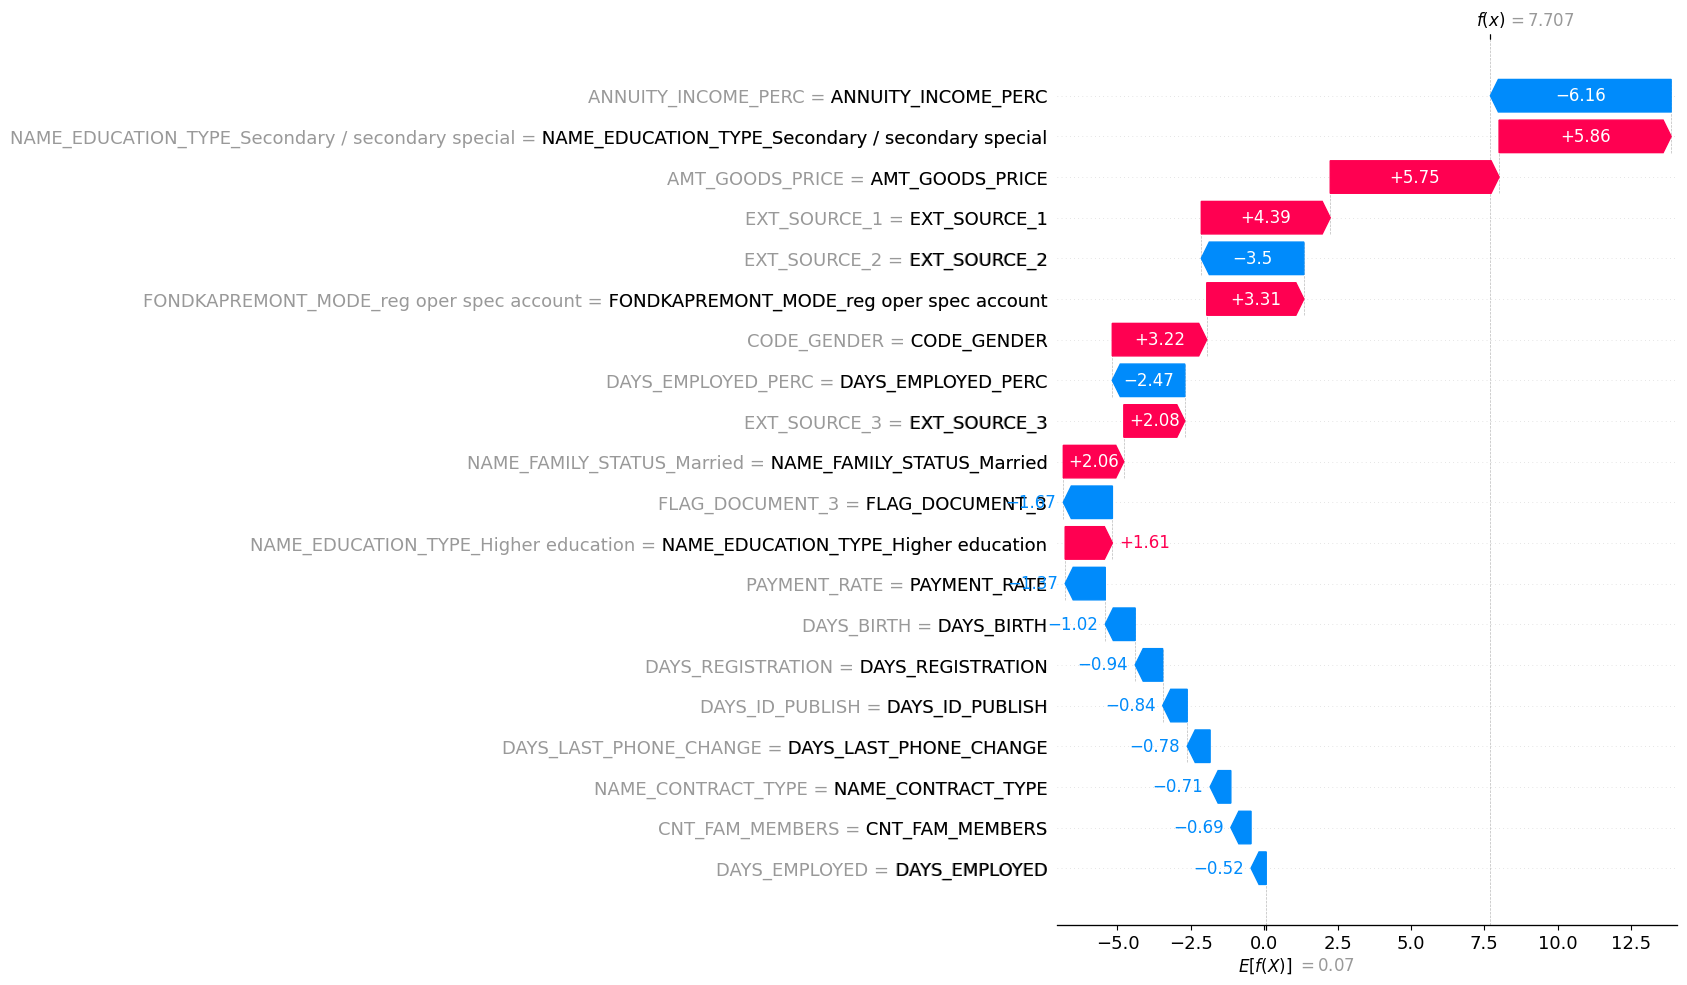

In [162]:
local_features(X_train_50000[features_kept_logistic_70], X_test_50000[features_kept_logistic_70], y_train_50000, 10000, pipe_lr_50000, 20)

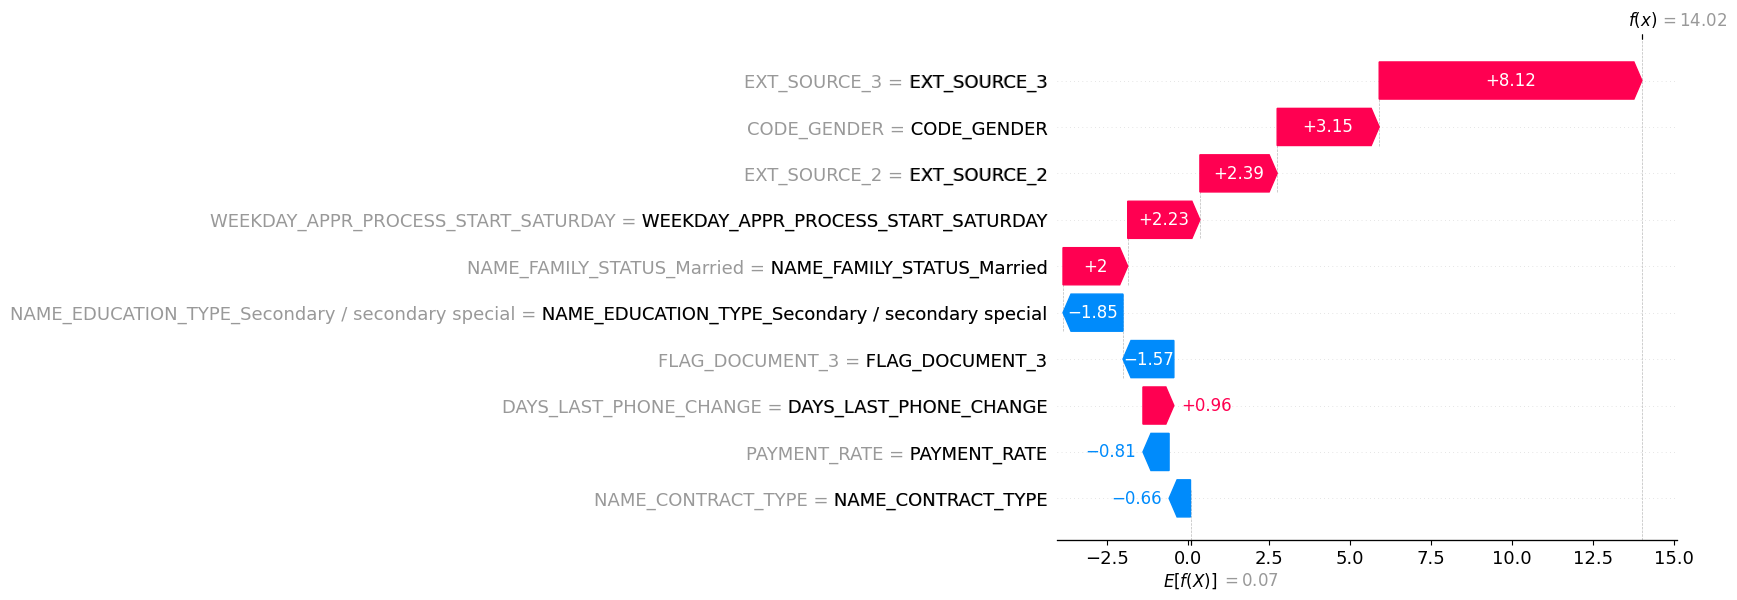

In [79]:
local_features(X_train_50000[features_kept_logistic_70], X_test_50000[features_kept_logistic_70], y_train_50000, 10000, pipe_lr_50000, 10)

## 10 Features 
### Features selection and train model

In [183]:
features_kept_logistic_10 = features_selection(df_10000, 
                                                LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5), 
                                                10)


In [184]:
features_kept_logistic_10

31                    EXT_SOURCE_1
32                    EXT_SOURCE_2
33                    EXT_SOURCE_3
78        DEF_30_CNT_SOCIAL_CIRCLE
89                 FLAG_DOCUMENT_9
99                FLAG_DOCUMENT_19
158    OCCUPATION_TYPE_Secretaries
182        ORGANIZATION_TYPE_Hotel
201     ORGANIZATION_TYPE_Military
252            ANNUITY_INCOME_PERC
Name: 0, dtype: object

In [163]:
fine_tune_model(df_50000, 
                5, 
                LogisticRegression(max_iter=500, class_weight='balanced'), 
                features_kept_logistic_10, 
                {'clf__C': [ 0.4, 0.5, 0.6, 0.7]} )

Best parameters : {'clf__C': 0.5}


In [165]:
evaluation(df_50000,
                            features_kept_logistic_10, 
                            5, 
                            LogisticRegression(max_iter=500, class_weight='balanced', C=0.5))

  folds  fit_time  score_time  validation_score  train_score
0   0.0  0.136777    0.014928          0.731690     0.717403
1   1.0  0.160037    0.011857          0.708885     0.723085
2   2.0  0.182342    0.013452          0.718943     0.720505
3   3.0  0.214663    0.011300          0.724224     0.719181
4   4.0  0.140997    0.008445          0.711805     0.722116
5  mean  0.166963    0.011996          0.719109     0.720458



Best threshold:	0.5526315789473684

roc_auc train: 	0.7203309318300316 
roc_auc test: 	0.7309039817075849
Cost train : 	57.87789389469473
Cost test: 	56.85


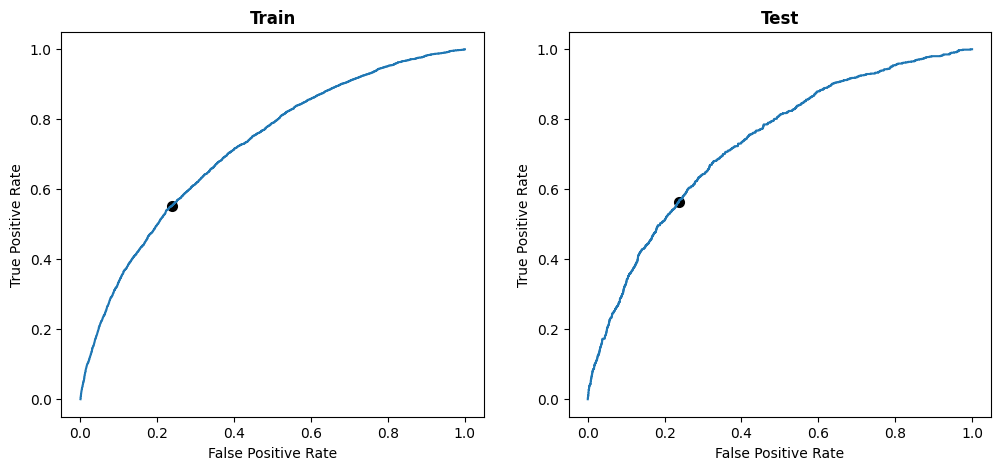

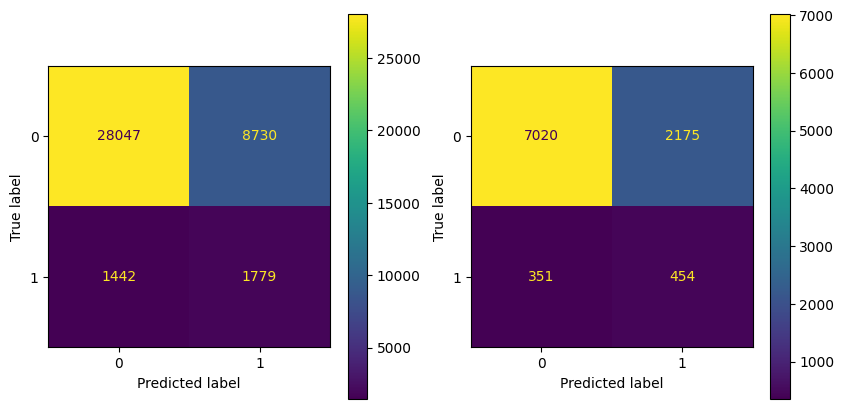

In [166]:
pipe_lr_10 = best_threshold(df_50000,
                            features_kept_logistic_10, 
                            LogisticRegression(max_iter=500, class_weight='balanced', C=0.5), 
                            0.5, 1)

### Features importance

,feature,importance
33,EXT_SOURCE_3,2.469144
252,ANNUITY_INCOME_PERC,2.064596
32,EXT_SOURCE_2,2.022781
31,EXT_SOURCE_1,1.780310
78,DEF_30_CNT_SOCIAL_CIRCLE,1.335633
158,OCCUPATION_TYPE_Secretaries,0.667189
201,ORGANIZATION_TYPE_Military,0.463617
89,FLAG_DOCUMENT_9,0.158365
182,ORGANIZATION_TYPE_Hotel,0.115618
99,FLAG_DOCUMENT_19,0.115091


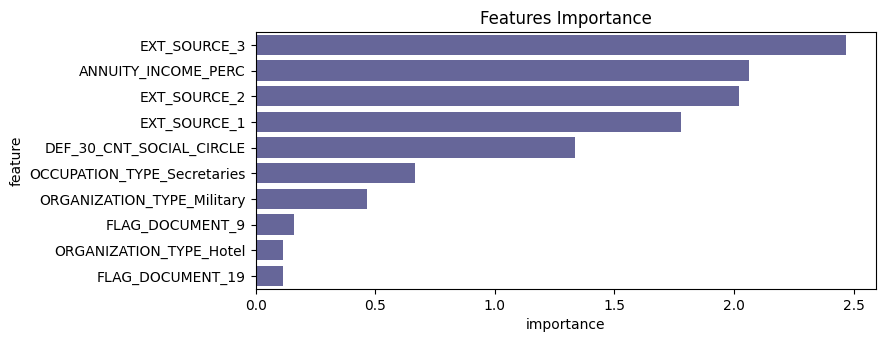

In [167]:
features_importance_from_coef(features_kept_logistic_10, pipe_lr_10, 10)

### Local features importance

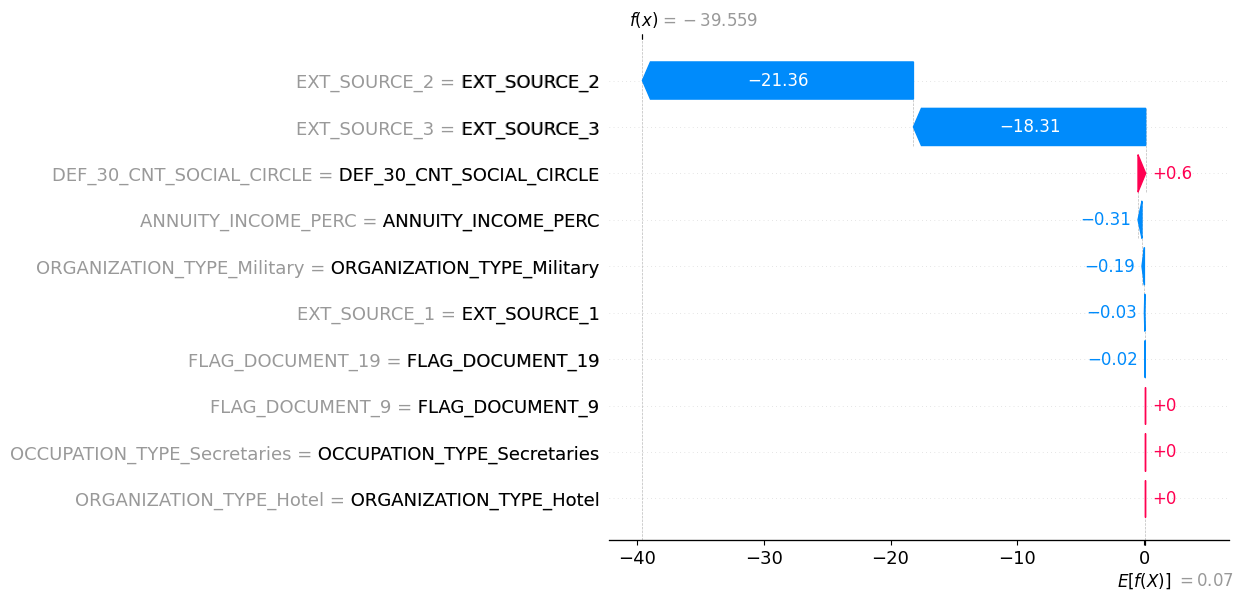

In [95]:
local_features(X_train_50000[features_kept_logistic_10], X_test_50000[features_kept_logistic_10], y_train_50000, 10000, pipe_lr_10, 10)

# lightgbm - balanced

In [99]:
lgbm_class = LGBMClassifier(
            n_estimators=150,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, 
            class_weight='balanced')

  folds  fit_time  score_time  validation_score  train_score
0   0.0  1.460389    0.057929          0.735543     0.919700
1   1.0  1.576122    0.053358          0.750082     0.918059
2   2.0  1.242777    0.048092          0.749454     0.920174
3   3.0  1.263635    0.042242          0.763468     0.917841
4   4.0  0.862729    0.032558          0.753535     0.919599
5  mean  1.281130    0.046836          0.750416     0.919075

Best threshold:	0.4571428571428572

roc_auc train: 	0.9159019582131306 
roc_auc test: 	0.7569612728385349
Cost train : 	28.1875
Cost test: 	53.900000000000006


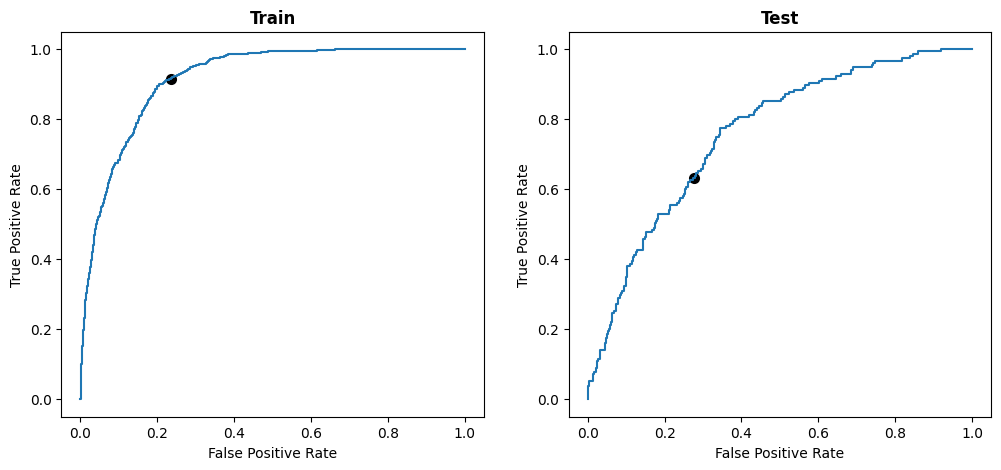

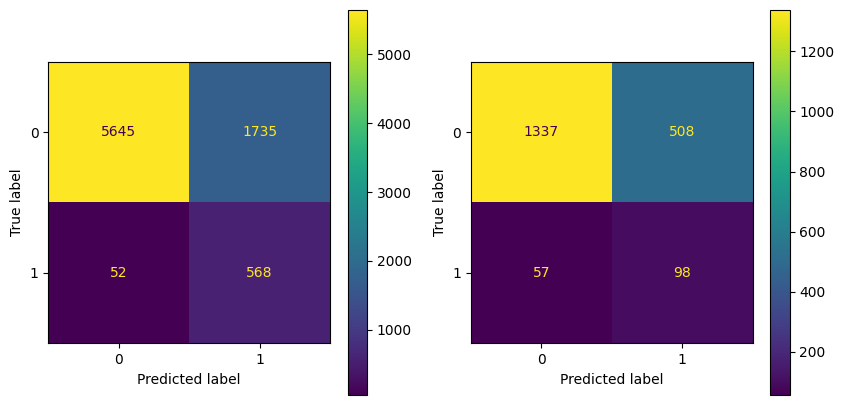

In [100]:
pipe_lgbm = best_threshold(df_10000, 
                            features, 5, 
                            lgbm_class, 0.2, 0.8)


In [ ]:
# overfitting important

### Bayesian optimization

In [112]:
def bo_params_lightgbm(learning_rate,
            num_leaves,
            colsample_bytree,
            subsample,
            max_depth,
            reg_alpha, 
            reg_lambda,
            min_split_gain,
            min_child_weight):
    
    params = {
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'max_depth': int(max_depth),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda, 
        'min_split_gain': min_split_gain, 
        'min_child_weight': min_child_weight,}
    
    clf = LGBMClassifier(n_estimators=150,
        class_weight='balanced',
        learning_rate=params['learning_rate'],
        num_leaves=params['num_leaves'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        max_depth=params['max_depth'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_split_gain=params['min_split_gain'], 
        min_child_weight=params['min_child_weight'])
    score = clf_result(clf,  df_10000, 5)
    return score

In [113]:
import bayes_opt
from bayes_opt import BayesianOptimization
rf_bo_lightgbm = BayesianOptimization(bo_params_lightgbm, {
        'learning_rate': [0.01, 0.1],
        'num_leaves': [20, 40],
        'colsample_bytree': [0.5, 1],
        'subsample': [0.5, 1],
        'max_depth': [5, 10],
        'reg_alpha': [0.01, 0.1],
        'reg_lambda': [0.01, 0.1], 
        'min_split_gain': [0.01, 0.1],
        'min_child_weight': [30, 50]})

In [114]:
results = rf_bo_lightgbm.maximize(n_iter=40, init_points=10, acq='ei')

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------



Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument



| 1         | 0.7471    | 0.9825    | 0.07013   | 8.404     | 32.25     | 0.05715   | 21.06     | 0.0587    | 0.02278   | 0.5544    |
| 2         | 0.745     | 0.8523    | 0.08579   | 5.466     | 35.1      | 0.05189   | 36.89     | 0.06751   | 0.07594   | 0.6295    |
| 3         | 0.7521    | 0.5066    | 0.0184    | 5.64      | 42.8      | 0.04629   | 39.99     | 0.03597   | 0.02423   | 0.5945    |
| 4         | 0.7375    | 0.6232    | 0.0975    | 7.116     | 34.7      | 0.06408   | 29.58     | 0.04246   | 0.03718   | 0.6892    |
| 5         | 0.7488    | 0.5699    | 0.01047   | 6.848     | 48.13     | 0.09013   | 23.36     | 0.02533   | 0.03414   | 0.645     |
| 6         | 0.7514    | 0.5413    | 0.03761   | 5.302     | 38.1      | 0.07152   | 36.7      | 0.06631   | 0.09664   | 0.9891    |
| 7         | 0.7419    | 0.5631    | 0.0995    | 8.175     | 45.81     | 0.06079   | 26.3      | 0.02014   | 0.05762   | 0.895     |
| 8         | 0.7503    | 0.826     | 0.02286   | 9.196     | 

In [ ]:
 iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |

In [ ]:
25        | 0.7568    | 0.6219    | 0.03233   | 5.699     | 47.82     | 0.08598   | 37.6      | 0.01415   | 0.04801   | 0.9479 

In [168]:
lgbm_opt = LGBMClassifier(
            nthread=4,
            n_estimators=150,
            learning_rate=0.03233  ,
            num_leaves=38,
            colsample_bytree=0.6219 ,
            subsample=0.9479 ,
            max_depth=6,
            reg_alpha=0.01415,
            reg_lambda=0.04801,
            min_split_gain=0.08598  ,
            min_child_weight=47.82,
            verbose=-1, 
            class_weight='balanced')

In [170]:
evaluation(df_50000, features_50000, 5, 
                            lgbm_opt)

  folds  fit_time  score_time  validation_score  train_score
0   0.0  8.219516    0.389854          0.760401     0.847900
1   1.0  8.140026    0.382087          0.736591     0.849477
2   2.0  7.474174    0.371244          0.755882     0.847989
3   3.0  7.523264    0.364899          0.752979     0.847301
4   4.0  6.381583    0.285022          0.739692     0.849063
5  mean  7.547713    0.358621          0.749109     0.848346


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1

Best threshold:	0.48421052631578954

roc_auc train: 	0.8406054153026156 
roc_auc test: 	0.7540151108319064
Cost train : 	41.74208710435522
Cost test: 	52.54


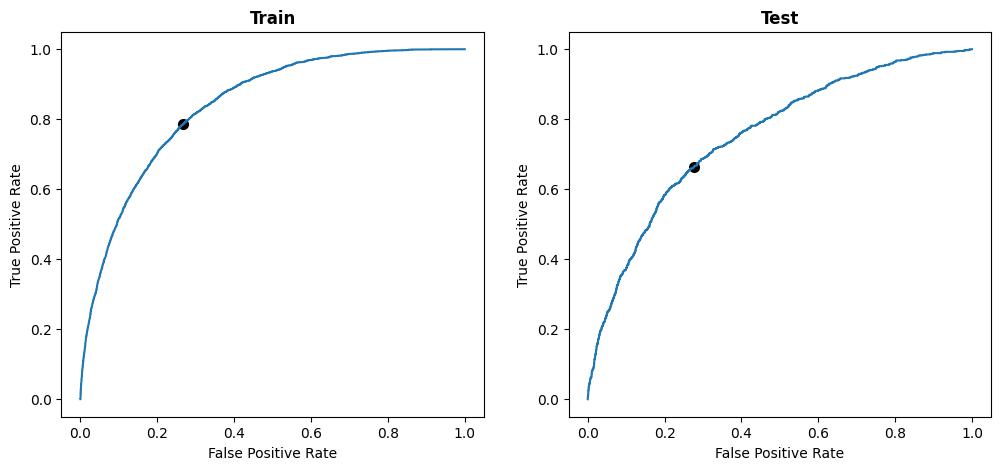

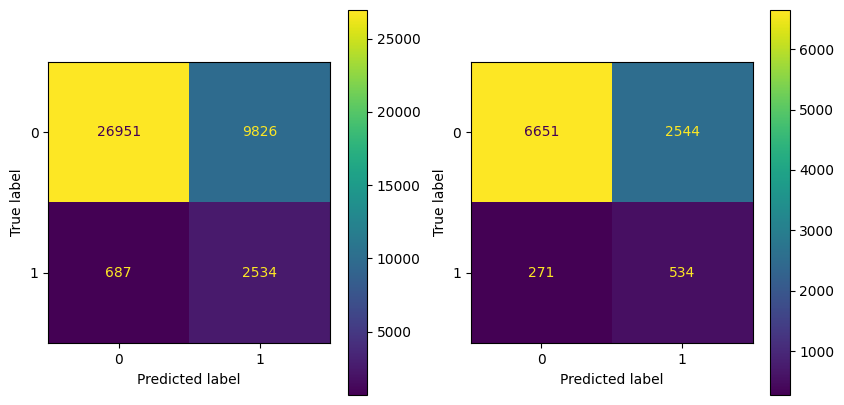

In [177]:
pipe_lgbm_opt = best_threshold(df_50000, 
                            features_50000,
                            lgbm_opt, 0.2, 0.8)

,feature,importance
33,EXT_SOURCE_3,325
32,EXT_SOURCE_2,317
255,PAYMENT_RATE,258
31,EXT_SOURCE_1,210
11,DAYS_EMPLOYED,160
8,AMT_GOODS_PRICE,157
10,DAYS_BIRTH,155
13,DAYS_ID_PUBLISH,154
12,DAYS_REGISTRATION,150
7,AMT_ANNUITY,149


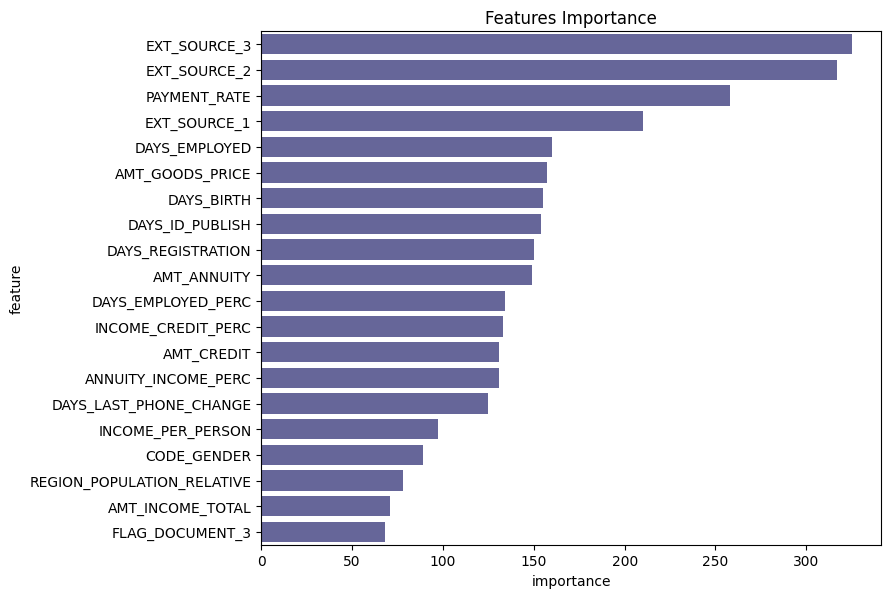

In [178]:
features_importance(features_50000, pipe_lgbm_opt, 20)

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


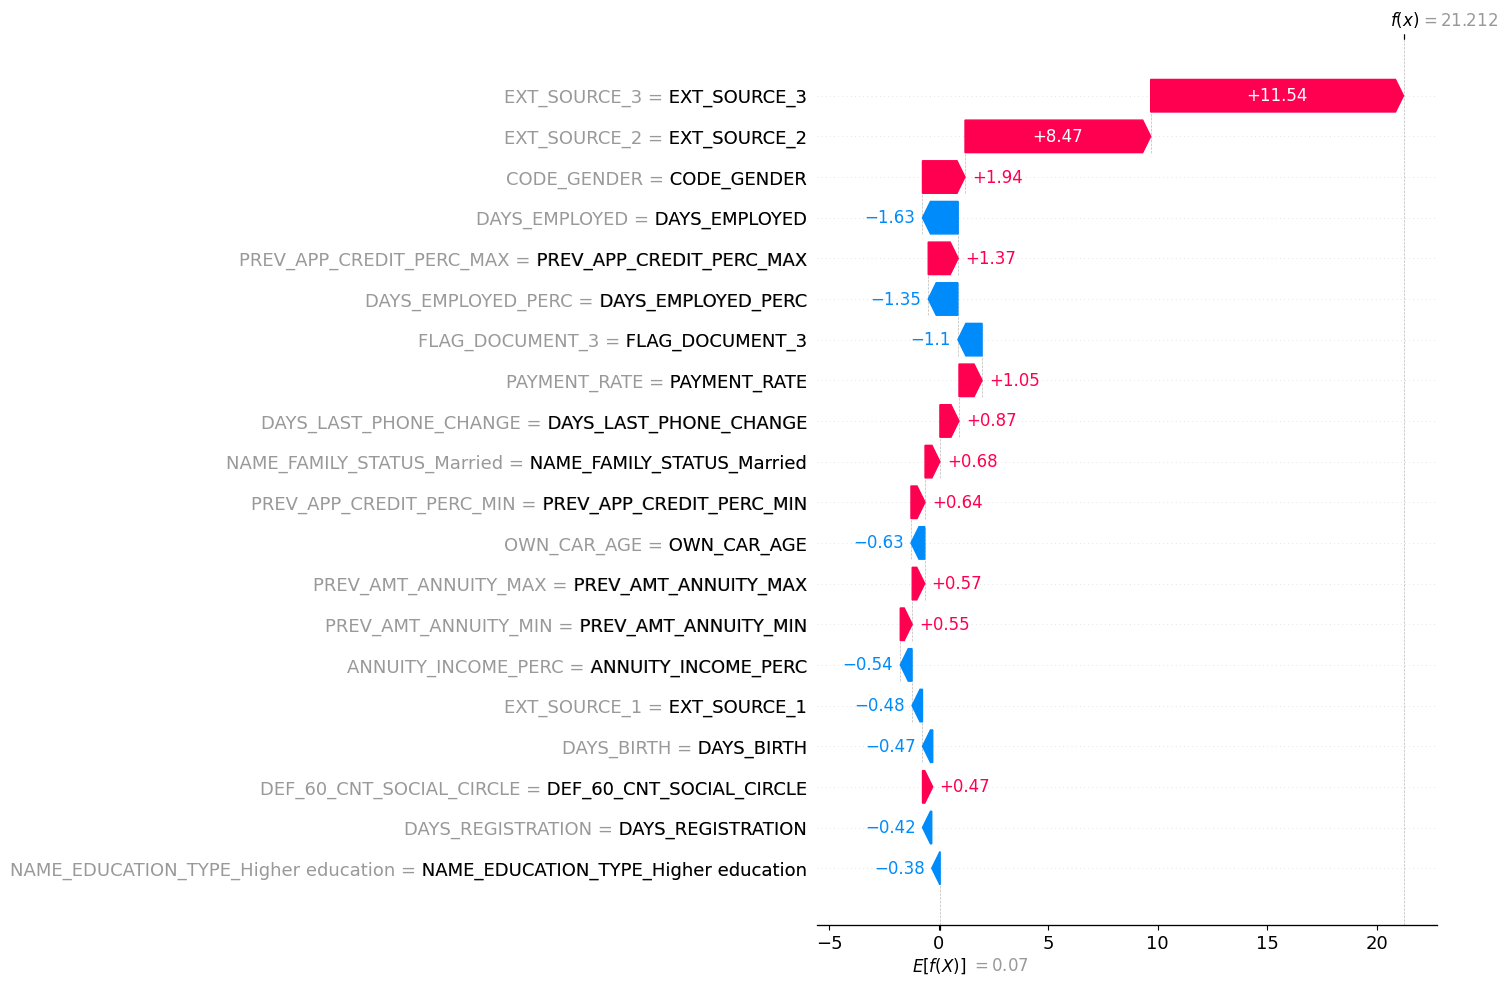

In [193]:
local_features(X_train_50000, X_test_50000, y_train_50000, 10000, pipe_lgbm_opt, 20)

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nth

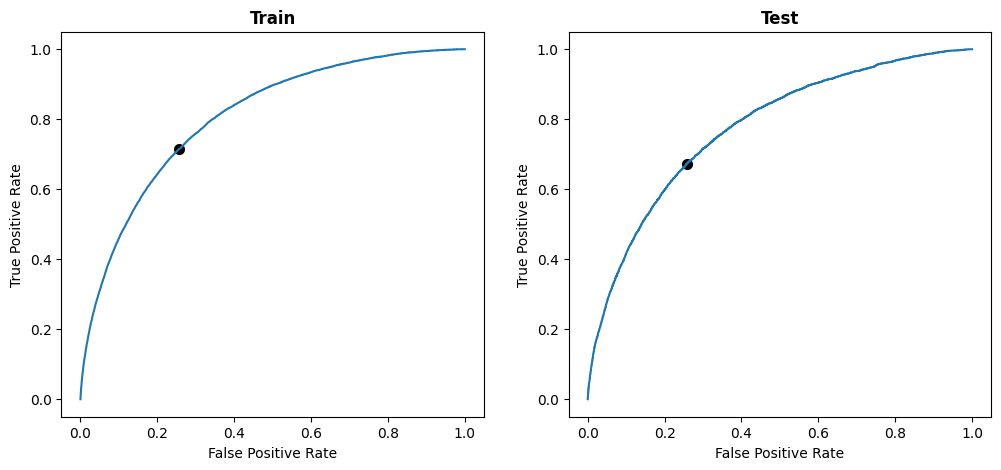

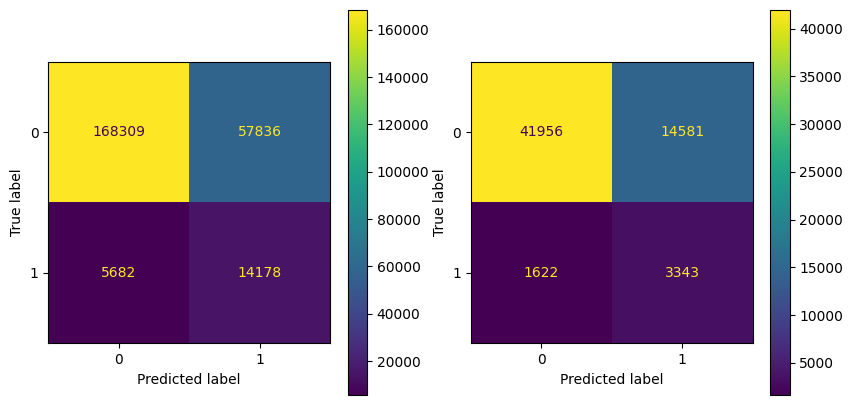

In [173]:
pipe_lgbm_opt = best_threshold(df_full, 
                            features_full,
                            lgbm_opt, 0.2, 0.8)

In [ ]:
# On peut constater que le surapprentissage diminue nettement avec le nombre d'individus